# COMP2002 Main Assignment
Machine Learning and Evolutionary Computation

In [32]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

## Part 1- Machine Learning

### 1.1 Data Preparation
The forest fire datasets are CSVs with the following fields:
<table><tr>
    <td>Day</td>
    <td>Month</td>
    <td>Year</td>
    <td>Temperature (degrees C)</td>
    <td>RH (Relative Humidity, %)</td>
    <td>WS (Wind speed, kmph)</td>
    <td>Rain (Total for day, mm)</td>
    <td>FFMC (Fine Fuel Moisture Code index)</td>
    <td>DMC (Duff Moisture Code index)</td>
    <td>DC (Drought Code index)</td>
    <td>ISI (Initial Spread Index)</td>
    <td>BUI (Buildup Index)</td>
    <td>FWI (Fire Weather Index)</td></tr></table>

In [33]:
# Read in forest fire datasets
ff_region1 = pandas.read_csv("datasets/AlgerianFF_Region1.csv")
ff_region2 = pandas.read_csv("datasets/AlgerianFF_Region2.csv")
ff_combined = pandas.concat([ff_region1, ff_region2])
# Normalise the data so that all features are in range 0-1, while also removing the year (every value is the same so it is not useful)
scaler = MinMaxScaler()  # Range 0-1 is default
ff_combined_inputs = scaler.fit_transform(ff_combined[["month", "Temperature", " RH", " Ws", "Rain ", "FFMC", "DMC", "DC", "ISI", "BUI"]])
# Randomly split into training and testing data (random_state given so that the same shuffle will be done on each run, making results reproducible)
ff_train_inputs, ff_test_inputs, ff_train_targets, ff_test_targets = train_test_split(ff_combined_inputs, ff_combined["FWI"], shuffle=True, random_state=1)

- The datasets for the two regions were combined and then randomly split into testing and training data (as opposed to using one region for training and the other for testing) in case there are any features that are not in the dataset that differentiate the two regions which could cause the models to overfit to the training region

### 1.2 Regression

In [34]:
# Random Forest Regressor
RF_regressor = RandomForestRegressor()
RF_regressor.fit(ff_train_inputs, ff_train_targets)

RandomForestRegressor()

In [35]:
# Neural Network
NN_regressor = MLPRegressor(max_iter=5750)
NN_regressor.fit(ff_train_inputs, ff_train_targets)

MLPRegressor(max_iter=5750)

In [36]:
# Support Vector Machine
SVM_regressor = SVR()
SVM_regressor.fit(ff_train_inputs, ff_train_targets)

SVR()

#### Tuning
##### Data Preparation
- Removed day from input data to see if this improved generalisability
    - The difference was negligible so day was not put back to improve compute time
- Tried using PCA with between 2 and 9 principal components
    - Even with 9 components, cross validation performance was considerably worse for all three models, so PCA was removed

##### Random Forest
- Increased `n_estimators` to 500, but performance impact was negligible, so it was reverted back to the default (100) as it increased compute time considerably
- Experimented with the different presets for `max_features` as having it too high can cause overfitting (Jermain, 2019)
    - Both "sqrt" and "log2" resulted in higher maximums on the boxplot, and caused the plot to skew towards higher values. The model was therefore reverted back to "auto" (which sets `max_features` to however many features there are)
- Experimented with different values for `max_depth` as the default value is no maximum depth, and having the depth too high can allow overfitting (Jermain, 2019)
    - Started from `max_depth=1` and worked upwards
    - Cross validation performance was much poorer but quickly improved as `max_depth` was incremented.  At `max_depth=5` the difference in performance compared with no maximum depth was negligible
    - But increasing `max_depth` further gave no further performance improvement, suggesting that the unlimited maximum depth is not causing overfitting.  It was therefore reverted back to the default
- Changed `min_samples_split`
    - Setting it to 5 (as opposed to the default of 2) had no impact on performance, but setting it to 10 reduced performance slightly so it was reverted back to the default
- Changed `min_samples_leaf`
    - Began increasing it from the default of 1.  This had no impact until it reached 5, at which point performance started to get worse so it was reverted back to the default
- Changed `max_leaf_nodes`
    - Initially this made performance worse, but by `max_leaf_nodes=20` it was not noticably different from the default.  Further increasing provided no performance gain so the parameter was reverted back to the default

Tuning seems to have little effect on the Random Forest, which is in keeping with its reputation for having good performance "out of the box" (Boehmke and Greenwell, 2020).

##### Neural Network
- The Neural Network model initially performed far worse than the other two, and was displaying "Convergence Warnings"
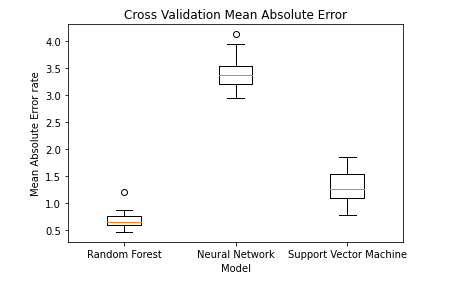
- This indicated that the model was reaching the maximum number of iterations before it was trained to a suitable level, meaning that the model could do better if it was allowed enough iterations
    - Starting from 500, the `max_iter` parameter was increased in large increments until the convergence warning stopped appearing.  When testing with `max_iter=5500` the model still showed the warning on one of the `RepeatedKFold` repeats so it was set to 5750 to give plenty of room for random variations in the number of iterations needed
    - The cross validation performance improved each time `max_iter` was incremented up until the convergence warnings stopped.  This suggests that not limiting the iterations is not causing overfitting.
        - Therefore `early_stopping` was not set to true
- Tried each of the activation functions offered by `MLPRegressor` but reverted back to the default ("relu")
    - "identity" gave worse cross validation results
    - "logistic" and "tanh" both gave convergence warnings.  It was decided that allowing any more iterations would take an unacceptable amount of compute time

### 1.3 Assessment of Regression

First, cross validation is used on the training data.  The results of this are then used to adjust the hyperparameters to improve performance.
- This is not done using the test data as otherwise the models might overfit to the test dataset (as it was used to tune the hyperparameters) so the test data would no longer give a reliable indication of how well the models generalise.

Once adjusting the hyperparameters no longer improves preformance on cross validation, the models are tested on the test data

c:\users\alex\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5750) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


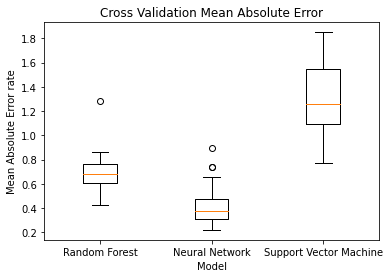

In [37]:
# Perform 5-fold cross validation. Done 5 times to reduce noise to get a result that is more comparable across runs.  random_state provided for reproducibility
cv = RepeatedKFold(n_repeats=5, random_state=1)
RF_scores = cross_val_score(RF_regressor, ff_train_inputs, ff_train_targets, scoring="neg_mean_absolute_error", cv=cv) * -1 # Uses the metrics.mean_absolute_error function to generate scores
NN_scores = cross_val_score(NN_regressor, ff_train_inputs, ff_train_targets, scoring="neg_mean_absolute_error", cv=cv) * -1  # The scores used by cross_val_score are negative so must be flipped to positive
SVM_scores = cross_val_score(SVM_regressor, ff_train_inputs, ff_train_targets, scoring="neg_mean_absolute_error", cv=cv) * -1

# Plot MAE from cross validation of each model as boxplots
plt.title("Cross Validation Mean Absolute Error")
plt.boxplot([RF_scores, NN_scores, SVM_scores], labels=["Random Forest", "Neural Network", "Support Vector Machine"])
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error rate")
plt.show()

# References
Jermain, N., 2019. Optimizing Hyperparameters for Random Forest Algorithms in scikit-learn. [Blog] Open Data Science, Available at: https://opendatascience.com/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn/ [Accessed 22 April 2021].

Boehmke, B. and Greenwell, B., 2020. Hands-On Machine Learning with R. [ebook] Chapter 11. Available at: https://bradleyboehmke.github.io/HOML/ [Accessed 25 April 2021].